# Two Rectangles or Triangles

## Import Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Generation

In [3]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x + width, y:y + height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size = 2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]

imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

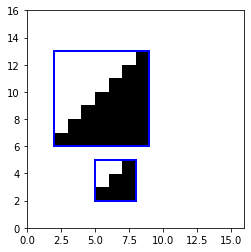

In [4]:
i = 3
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec='r' if shape[0] == 0 else 'b', fc='none'))

## Preprocessing

In [5]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), 1.29414257088456e-16, 1.000000000000002)

In [6]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis = -1).reshape(num_imgs, -1)
y.shape

(50000, 10)

## Train Test Split

In [7]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 68,362
Trainable params: 68,362
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [9]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    w_I = max(w_I, 0)  # set w_I and h_I zero if there is no intersection
    h_I = max(h_I, 0)
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating Function

In [10]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [11]:
# Flip bboxes during training.
num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))
mses = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        if mse_flipped < mse:  
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
            mses[i, epoch] = mse_flipped / 2.
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            mses[i, epoch] = mse / 2.
            
    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses[:, epoch])))

Epoch 0
1250/1250 [==============================] - 3s 2ms/step - loss: 0.1007 - val_loss: 0.0516
Flipped 4608.0 training samples (11.52 %)
Mean IOU: 0.12434850951888493
Mean dist: 0.1317837333210995
Mean mse: 0.024891173562962315
Epoch 1
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0519 - val_loss: 0.0481
Flipped 2639.0 training samples (6.5975 %)
Mean IOU: 0.13414989409567996
Mean dist: 0.1370642387406094
Mean mse: 0.022803483684475965
Epoch 2
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0493 - val_loss: 0.0473
Flipped 1880.0 training samples (4.7 %)
Mean IOU: 0.13831240630364633
Mean dist: 0.1413406762850663
Mean mse: 0.022181555523393348
Epoch 3
1250/1250 [==============================] - 3s 2ms/step - loss: 0.0480 - val_loss: 0.0472
Flipped 1626.0 training samples (4.0649999999999995 %)
Mean IOU: 0.13636144697809627
Mean dist: 0.143182244549104
Mean mse: 0.02169421166456255
Epoch 4
1250/1250 [==============================] - 3s 2ms/st

KeyboardInterrupt: 

## Flipping Track

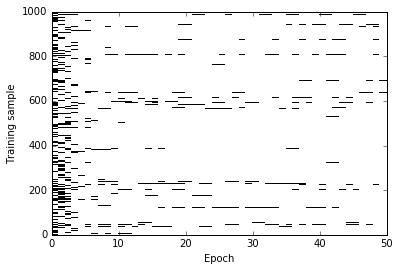

In [9]:
plt.pcolor(flipped[:1000], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

## Metrics Track

(0, 1)

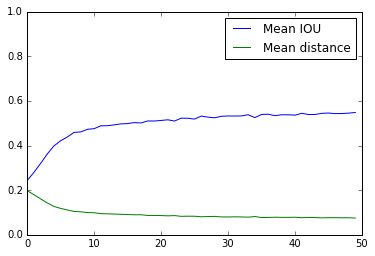

In [10]:
plt.plot(np.mean(ious, axis = 0), label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis = 0), label = 'Mean distance')  # relative to image size
plt.legend()
plt.ylim(0, 1)

## Denormalize Data

In [11]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000L, 2L, 4L), (10000L, 2L, 1L))

## Visualize Results

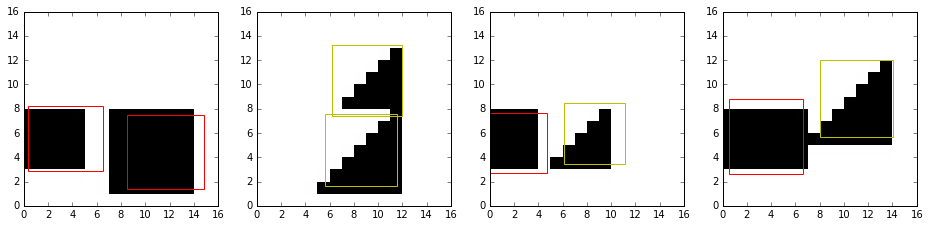

In [31]:
plt.figure(figsize = (16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r' if pred_shape[0] <= 0.5 else 'b', fc = 'none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

plt.savefig('two-rectangles-or-triangles.png', dpi = 100)